__Import Libraries__

In [3]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim 
import requests # library to handle requests

from pandas import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
import requests
import lxml.html as lh

__Get the Toronto - 103 FSAs data of the HTML table__

In [4]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(url)
doc = lh.fromstring(page.content)
tr_elements = doc.xpath('//tr')

In [5]:
#Check the length of the first 12 rows
[len(T) for T in tr_elements[:12]]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

__Parse Table Header__

In [6]:
#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    name = name.strip().replace('\n', ' ')
    #print (i,name)
    col.append((name,[]))

__Extract table data__

In [7]:
#Since our first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 10, the //tr data is not from our table 
    if len(T)!=3:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content()
        data = data.strip().replace('\n', ' ')
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

__Create Pandas DataFrame and apply conditions given in the Assignment__

In [8]:
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)
df.drop(df.loc[df['Borough']=='Not assigned'].index, inplace=True)
df.drop(df.loc[df['Postal code']==''].index, inplace=True)
df = df.reset_index(drop=True)
df.groupby(['Postal code', 'Borough']).agg(lambda x: ','.join(set(x)))
df['Neighborhood'] = df['Neighborhood'].str.replace('/',',')
df['Neighborhood'] = np.where(df['Neighborhood'] == 'Not assigned', df['Borough'], df['Neighborhood'] )
df.head()

,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government"


In [9]:
df.shape

(103, 3)

__Load Toronto Geospatial Data__

In [22]:
url1 = 'http://cocl.us/Geospatial_data'
trnt_geo_data = pd.read_csv(url1)
trnt_geo_data.rename(columns = {'Postal Code':'Postal code'}, inplace = True) 
trnt_geo_data
trnt_geo_data.head()


,Postal code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


__validate number of unique postal codes__

In [25]:
print('The dataframe has {} unique Postal codes'.format(
        len(trnt_geo_data['Postal code'].unique())
    )
)

The dataframe has 103 unique Postal codes


__Join Neighborhood Dataframe with Geospatial Dataframe__

In [27]:
neighborhoods = df.merge(trnt_geo_data, left_on=['Postal code'], right_on = ['Postal code'], how='left')
neighborhoods.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494


__Geographical coordinates of Toronto__

In [28]:
tor_lat = 43.651070
tor_long = -79.347015
print('The geograpical coordinate of Toronto, Ontario are {}, {}.'.format(tor_lat, tor_long))

The geograpical coordinate of Toronto, Ontario are 43.65107, -79.347015.


__Create a map of Toronto with neighborhoods superimposed on top__

In [29]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[tor_lat, tor_long], zoom_start=10)

# add markers to map
for lat, lng, post_code, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Postal code'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Populating the interactive namespace from numpy and matplotlib


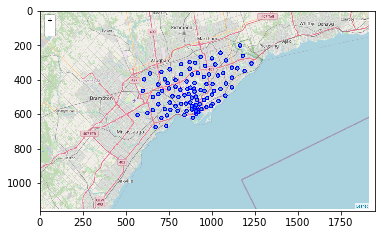

In [90]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(r'C:\Users\samni\Documents\SAMs FOLDER\[0] 0 0 0 2 DATA SCIENCE\[0] COUSERA\16 Applied Data Science Capstone\map_toronto.png')
imgplot = plt.imshow(img)
plt.show()

__Define Foursquare Credentials and Version__

In [1]:
CLIENT_ID = 'CLIENT_ID' # your Foursquare ID
CLIENT_SECRET = 'CLIENT_SECRET' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CLIENT_ID
CLIENT_SECRET:CLIENT_SECRET


__Let's explore the first neighborhood in our dataframe__

In [31]:
neighborhoods.loc[0, 'Neighborhood']

'Parkwoods'

__Get the neighborhod's coordinates__

In [32]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


__Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters__

In [33]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=YIOZ12CC5OTPGJCHS04O1CRDMSDI2WD4WQODQJ2NVXJYET3N&client_secret=KKWSFXR1BCJD4VXP03QEGNZMXYN24AUOLZ4KS52EXTD1HROK&v=20180605&ll=43.7532586,-79.3296565&radius=500&limit=100'

__JSON results__

In [34]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eadce9cbe61c90022b1eb45'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Parkwoods - Donalda',
  'headerFullLocation': 'Parkwoods - Donalda, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 2,
  'suggestedBounds': {'ne': {'lat': 43.757758604500005,
    'lng': -79.32343823984928},
   'sw': {'lat': 43.7487585955, 'lng': -79.33587476015072}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e8d9dcdd5fbbbb6b3003c7b',
       'name': 'Brookbanks Park',
       'location': {'address': 'Toronto',
        'lat': 43.751976046055574,
        'lng': -79.33214044722958,
        'labeledLatLngs': 

__Define get_category_type function__

In [35]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

__Clean the json and structure it into a pandas dataframe__

In [36]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,Variety Store,Food & Drink Shop,43.751974,-79.333114


__And how many venues were returned by Foursquare?__

In [37]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

2 venues were returned by Foursquare.


## Explore Neighborhoods in Toronto

__Let's create a function to repeat the same process to all the neighborhoods in Toronto__

In [38]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url3 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url3).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

__Now write the code to run the above function on each neighborhood and create a new dataframe called toronto_venues.__

In [40]:
# type your answer here

toronto_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )




Parkwoods
Victoria Village
Regent Park , Harbourfront
Lawrence Manor , Lawrence Heights
Queen's Park , Ontario Provincial Government
Islington Avenue
Malvern , Rouge
Don Mills
Parkview Hill , Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park , Princess Gardens , Martin Grove , Islington , Cloverdale
Rouge Hill , Port Union , Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate , Bloordale Gardens , Old Burnhamthorpe , Markland Wood
Guildwood , Morningside , West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor , Wilson Heights , Downsview North
Thorncliffe Park
Richmond , Adelaide , King
Dufferin , Dovercourt Village
Scarborough Village
Fairview , Henry Farm , Oriole
Northwood Park , York University
East Toronto
Harbourfront East , Union Station , Toronto Islands
Little Portugal , Trinity
Kennedy Park , Ionview , East Birchmount Park
Bayview Village
Do

__Let's check the size of the resulting dataframe__

In [41]:
print(toronto_venues.shape)
toronto_venues.head()

(2151, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


__Let's find out how many unique categories can be curated from all the returned venues__

In [42]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 267 uniques categories.


## Analyze Each Neighborhood

In [43]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

__Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category__

In [45]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

__Let's print each neighborhood along with the top 5 most common venues__

In [46]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0             Clothing Store   0.2
1               Skating Rink   0.2
2                     Lounge   0.2
3             Breakfast Spot   0.2
4  Latin American Restaurant   0.2


----Alderwood , Long Branch----
          venue  freq
0   Pizza Place   0.2
1      Pharmacy   0.1
2  Dance Studio   0.1
3  Skating Rink   0.1
4           Gym   0.1


----Bathurst Manor , Wilson Heights , Downsview North----
           venue  freq
0           Bank  0.11
1    Coffee Shop  0.11
2    Bridal Shop  0.05
3  Deli / Bodega  0.05
4     Restaurant  0.05


----Bayview Village----
                 venue  freq
0                 Café  0.25
1  Japanese Restaurant  0.25
2                 Bank  0.25
3   Chinese Restaurant  0.25
4          Yoga Studio  0.00


----Bedford Park , Lawrence Manor East----
                venue  freq
0         Coffee Shop  0.08
1          Restaurant  0.08
2      Sandwich Place  0.08
3    Sushi Restaurant  0.08
4  Italian Restaurant  

__Let's put that into a pandas dataframe__

__First, let's write a function to sort the venues in descending order__

In [47]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood

In [48]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Clothing Store,Breakfast Spot,Skating Rink,Event Space,Ethiopian Restaurant,Electronics Store,Dim Sum Restaurant,Eastern European Restaurant
1,"Alderwood , Long Branch",Pizza Place,Gym,Pub,Sandwich Place,Dance Studio,Athletics & Sports,Skating Rink,Coffee Shop,Pharmacy,Concert Hall
2,"Bathurst Manor , Wilson Heights , Downsview North",Coffee Shop,Bank,Shopping Mall,Bridal Shop,Ice Cream Shop,Supermarket,Middle Eastern Restaurant,Sushi Restaurant,Fried Chicken Joint,Restaurant
3,Bayview Village,Café,Bank,Chinese Restaurant,Japanese Restaurant,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
4,"Bedford Park , Lawrence Manor East",Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Sushi Restaurant,Thai Restaurant,Pharmacy,Pizza Place,Cosmetics Shop,Pub


## Cluster Neighborhoods

Run k-means to cluster the neighborhood into 5 clusters

In [49]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [59]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labelz', kmeans.labels_)

toronto_merged = neighborhoods
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!


,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster Labbelz,Cluster Labelz,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,3.0,3.0,3.0,Food & Drink Shop,Park,Women's Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,1.0,1.0,Hockey Arena,Coffee Shop,Intersection,Portuguese Restaurant,French Restaurant,Pizza Place,Eastern European Restaurant,Electronics Store,Drugstore,Donut Shop
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,1.0,1.0,1.0,Coffee Shop,Park,Bakery,Pub,Theater,Breakfast Spot,Café,Shoe Store,Restaurant,Chocolate Shop
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763,1.0,1.0,1.0,Clothing Store,Furniture / Home Store,Coffee Shop,Boutique,Shoe Store,Sporting Goods Shop,Miscellaneous Shop,Arts & Crafts Store,Women's Store,Vietnamese Restaurant
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494,1.0,1.0,1.0,Coffee Shop,Sushi Restaurant,Diner,Yoga Studio,Burger Joint,Bank,Bar,Beer Bar,Italian Restaurant,Japanese Restaurant


Drop rows where Cluster Labels are Null

In [80]:
toronto_merged.drop(['Cluster Labbelz', 'Cluster Labelz'], axis=1, inplace=True)
toronto_merged = toronto_merged[pd.notnull(toronto_merged['Cluster Labels'])]
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype('Int64')
toronto_merged.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,3,Food & Drink Shop,Park,Women's Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,M4A,North York,Victoria Village,43.725882,-79.315572,1,Hockey Arena,Coffee Shop,Intersection,Portuguese Restaurant,French Restaurant,Pizza Place,Eastern European Restaurant,Electronics Store,Drugstore,Donut Shop
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,1,Coffee Shop,Park,Bakery,Pub,Theater,Breakfast Spot,Café,Shoe Store,Restaurant,Chocolate Shop
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763,1,Clothing Store,Furniture / Home Store,Coffee Shop,Boutique,Shoe Store,Sporting Goods Shop,Miscellaneous Shop,Arts & Crafts Store,Women's Store,Vietnamese Restaurant
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Sushi Restaurant,Diner,Yoga Studio,Burger Joint,Bank,Bar,Beer Bar,Italian Restaurant,Japanese Restaurant


Visualize the resulting clusters

In [81]:
# create map
map_clusters = folium.Map(location=[tor_lat, tor_long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Populating the interactive namespace from numpy and matplotlib


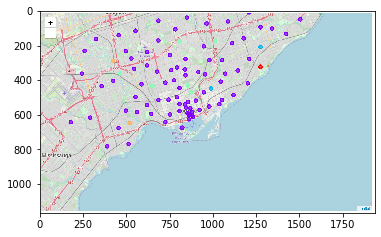

In [89]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(r'C:\Users\samni\Documents\SAMs FOLDER\[0] 0 0 0 2 DATA SCIENCE\[0] COUSERA\16 Applied Data Science Capstone\map_clusters.png')
imgplot = plt.imshow(img)
plt.show()

## Examine Clusters

### Cluster 1

In [82]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
51,Scarborough,0,Motel,American Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Department Store


### Cluster 2

In [83]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,1,Hockey Arena,Coffee Shop,Intersection,Portuguese Restaurant,French Restaurant,Pizza Place,Eastern European Restaurant,Electronics Store,Drugstore,Donut Shop
2,Downtown Toronto,1,Coffee Shop,Park,Bakery,Pub,Theater,Breakfast Spot,Café,Shoe Store,Restaurant,Chocolate Shop
3,North York,1,Clothing Store,Furniture / Home Store,Coffee Shop,Boutique,Shoe Store,Sporting Goods Shop,Miscellaneous Shop,Arts & Crafts Store,Women's Store,Vietnamese Restaurant
4,Downtown Toronto,1,Coffee Shop,Sushi Restaurant,Diner,Yoga Studio,Burger Joint,Bank,Bar,Beer Bar,Italian Restaurant,Japanese Restaurant
6,Scarborough,1,Fast Food Restaurant,Print Shop,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Deli / Bodega
7,North York,1,Gym,Restaurant,Beer Store,Japanese Restaurant,Coffee Shop,Asian Restaurant,Concert Hall,Chinese Restaurant,Bike Shop,Italian Restaurant
8,East York,1,Pizza Place,Pharmacy,Athletics & Sports,Gastropub,Intersection,Fast Food Restaurant,Pet Store,Breakfast Spot,Bank,Gym / Fitness Center
9,Downtown Toronto,1,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Italian Restaurant,Japanese Restaurant,Restaurant,Middle Eastern Restaurant,Cosmetics Shop,Theater
10,North York,1,Park,Japanese Restaurant,Pub,Metro Station,Pizza Place,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
12,Scarborough,1,Construction & Landscaping,History Museum,Bar,Women's Store,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant


### Cluster 3

In [84]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Scarborough,2,Playground,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
35,East York,2,Park,Coffee Shop,Convenience Store,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
85,Scarborough,2,Park,Playground,Coffee Shop,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run


### Cluster 4

In [85]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,3,Food & Drink Shop,Park,Women's Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
21,York,3,Park,Women's Store,Spa,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Eastern European Restaurant
64,York,3,Park,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
66,North York,3,Park,Convenience Store,Bank,Bar,Women's Store,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant
83,Central Toronto,3,Park,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
91,Downtown Toronto,3,Park,Trail,Playground,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run


### Cluster 5

In [86]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,North York,4,Paper / Office Supplies Store,Baseball Field,Women's Store,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
101,Etobicoke,4,Baseball Field,Women's Store,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Field
